# UCLA Datafest 2018
## Team Neighbors
## John Atherton, Dominique McDonald, and James Lo
***

## Introduction

The United States, over the last half-century, has become more and more unfriendly for unskilled workers. As well-paid unskilled jobs were shifted overseas and as entire industries fell into decline, many people lost their jobs and livelihoods. Much of rural America has yet to recover from the Great Recession of 2008, and housing and other necessities continue to become more and more expensive and unaffordable, especially in urban areas. Financial stress doesn't just damage mental health, but is detrimental to the body as well.

Is there any place left in America where someone with a high school diploma and little to no professional experience can easily find a job that more than covers the cost of living? 

To answer that question, we decided to come up with a comprehensive index of the quality of the unskilled labor market, taking into account three standardized measurements in different weights:

1. Living Wage Index: 
    - The Living Wage Calculator is a project by Dr. Amy K. Glasmeier at MIT to localize cost of living down to the county level. We take the median wage in each of these counties and divide it by the living wage. The result is a number that captures the strength of wages against the cost of living.
2. Competitiveness Index: 
    - How much competition do job postings see? We get this number by calculating the length of time postings were active and summing all postings for a given county, and then dividing by the total number of clicks these postings got. 
3. Market Size Index:
    - How many jobs are there compared to the number of unemployed? We take this by summing the number of unique jobs and dividing by the unemployed population in each county.

***
## About the data

The dataset we're using was graciously supplied by Indeed, and contains anonymized information about selected job postings over the course of a year. 

Each row is an individual listing on a given day. Since a job listing almost always exist for more than one day, distinct jobs will usually have more than one record. They're uniquely identified by "jobId", and contain information about the location, industry, salary, and necessary qualifications for each job.
<br>
### Assumptions

For the purposes of this project unskilled labor means:
  1. Requires at most a high school degree
  2. No management duties
  3. No kind of license is required
  4. Requires from 0 to 2 years of experience

Since the data isn't totally accurate, we have to go through the filtered list and exclude some specific jobs based on the title and also salary. We're limiting the scope of our analysis to the 50 United States.

Because we don't know if this dataset was randomly sampled from all possible listings, we cannot be sure that it is representative of all postings on Indeed, and neither can we be sure that the data on Indeed itself is truly representative of a regional job market.
However, we're working under the assumptions that:
  1. The dataset is a random sample from Indeed's listings
  2. The dataset is representative of the true job market in terms of wages
  3. Clicks accurately reflect total interest in a job
  4. When jobs disappear from Indeed, they've been filled


### Methods
We'll be using data tables in this notebook. They're written in C and are extremely fast. We'll start off by loading packages and downloading the necessary data. The rest (meaning the data not publically accessible) is in this project folder.

***
## Data cleaning/preprocessing

In [ ]:
library(data.table)
library(plyr)
library(dplyr)
library(ggplot2)
library(gtable)
library(gridExtra)
library(readxl)
library(stringr)
library(plotly)
library(repr)
library(OneR)
library(ggpubr)

d <- fread("~/projects/datafest/project_data/data.csv")

download.file(
    "https://www.bls.gov/lau/laucnty17.xlsx",
    "project_data/laucnty17.xlsx"
)
download.file(
    "https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv",
    "project_data/zip_codes.csv"
)

Since the data table is so huge and unwieldy, we throw out the columns we don't care about. We then filter out skilled/non-US jobs as well as those with missing data. We won't make any assumptions about the distribution of missing data, except that it's uniform across all job types.

In [2]:
d[, descriptionCharacterLength := NULL]
d[, numReviews := NULL]
d[, jobLanguage := NULL]
d[, companyId := NULL]
d[, supervisingJob := as.integer(supervisingJob)]
d[, licenseRequiredJob := as.integer(supervisingJob)]

d <- d[(country == "US" 
        & supervisingJob == 0 
        & licenseRequiredJob == 0 
        & (educationRequirements == "None" | educationRequirements == "High School"))]

d <- d[(stateProvince != "MP" 
        & stateProvince != "PR")]

d <- d[(!is.na(experienceRequired) 
        & (experienceRequired >= 0 & experienceRequired <= 2))  
        & (city != "" & (!is.na(city) & city != "UNKNOWN")) 
        & (stateProvince != "" 
        & (stateProvince != "UNKNOWN" 
        & !is.na(stateProvince)))]

***
## Joining with external data

Since we're bringing in a lot of external data (while trying not to lose what we have now), we'll be doing a lot of left and inner joins. We might as well try to make it easy for ourselves by creating a simple field to join on. This will be called `composite`.

We regularize the spelling of `city`, and define the field `composite`, which is the city and the state pasted together. We'll be joining with this column as a unique ID later.

In [3]:
d[, city := gsub("[^A-Za-z\\ ]+", "", gsub("St ", "Saint ", city))]
d[, lower.city := tolower(city)]
d[, composite := paste(lower.city, stateProvince)]


Next, we read in city/state/county information to match against our `composite` column. Note that it also has a column `alias`: if we don't have a match with the `city` + `state` fields, we'll then match against `alias` + `state`. It's simply an alternate name for that city. We define another composite column to match against the posting data.


In [4]:
zip.codes = fread("project_data/zip_codes.csv", sep='|', fill = TRUE)

names(zip.codes) = c("city", "state", "state.long", "county", "alias")

zip.codes[, city := gsub("[^A-Za-z\\ ]+", "", city)]
zip.codes[, alias := gsub("[^A-Za-z\\ ]+", "", alias)]
zip.codes[, city := gsub("St ", "Saint ", city)]
zip.codes[, alias := gsub("St ", "Saint ", alias)]

zip.codes[, alias := tolower(alias)]
zip.codes[, city := tolower(city)]
zip.codes[, composite := paste(city, state, sep=" ")]
zip.codes[, composite2 := paste(alias, state, sep=" ")]

We'd like to calculate how long distinct jobs had an active posting. We first convert to POSIX time, and subtract the smallest (the earliest time) from the largest (the latest time) to get the number of days on the market. 

Because each row is a unique job on a unique day, we group by job, and calculate the time active, while also taking the sum of clicks, and saving the location/industry/salary information along with it. After that, we filter out skilled jobs that made it into our dataset by comparing the titles against a list of strings. This list was created by manual inspection.

In [ ]:
d[, posix.date := as.numeric(as.POSIXct(date))]
seconds.per.day = (60 * 60 * 24)
d.job.sum <- d %>% 
    group_by(jobId) %>% 
    summarize( 
        days = (max(posix.date) - min(posix.date)) / seconds.per.day,
        total.clicks = sum(clicks),
        salary=estimatedSalary[1],
        composite=composite[1],
        state = stateProvince[1],
        city=city[1],
        industry=industry[1],
        title = normTitle[1],
        category = normTitleCategory[1]
    ) 

d.job.sum <- as.data.table(d.job.sum)

skilled.titles <- c("senior", "lead", "nurse", "medical", "manager", "therapist",
                    "phlebotomist", "developer", "engineer", "electrician",
                    "pharmacy", "pharmacist", "java", "clinic", "licensed",
                    "certified", "accountant", "supervisor", "sonographer",
                    "specialist", "paralegal", "designer", "head", "principal",
                    "scientist", "professor", "chief", "primary", "physician",
                    "orthopedist", "attorney","architect", "general practitioner",
                    "lecturer", "captain", "teacher", "president", "intern",
                    "plumber", "psychiatrist", "faculty", "principle", "carpenter",
                    "resident", "doctoral", "director", "emt", "anesthesia",
                    "student", "tax","psychologist", "underwriter", "foreman",
                    "optician", "nuclear", "neurologist", "account executive",
                    "commander", "mathematician", "chemist", "radiologist")

for (i in skilled.titles) 
  d.job.sum <- d.job.sum[(!title %like% i)]


Since not all of the labels were totally accurate, we'll say that all jobs above $100,000 salary were mislabeled.


In [ ]:
d.job.sum <- d.job.sum[salary < 100000]


Now we'll merge the city/county/state information with the job data. First we attempt to match with city + state, and then alias + state. Setting the key sorts each data table according to that column and makes joining faster.


In [ ]:
setkey(zip.codes, composite)
setkey(d.job.sum, composite)

d.job.sum <- merge(d.job.sum,
                   unique(zip.codes[,list(state,state.long)],on=state),
                   by="state",
                   all.x=T)

d.job.sum <-  merge(d.job.sum,
                    unique(zip.codes[,list(composite, county)], on="composite"),
                    by="composite",
                    all.x=T)

d.job.sum <- merge(d.job.sum,
                   unique(zip.codes[,list(composite2, county)], on="composite2"),
                   by.x="composite",
                   by.y="composite2",
                   all.x = T)

d.job.sum[, county := ifelse(is.na(county.x), county.y, county.x)]

d.job.sum[, county.x := NULL]
d.job.sum[, county.y := NULL]
d.job.sum <- unique(d.job.sum, by="jobId")
d.job.sum <- d.job.sum[!is.na(county)]

Now we need to aggregate information on the county level: we save the average number of days a listing was active, the average number of clicks per day, the total number of unique jobs posted over the course of the year, and city/state information. We then exclude counties with less than three unique jobs, because outliers would have an undue effect on the results.

In [ ]:
fullmerged <-   d.job.sum %>%
                group_by(county, state.long) %>% 
                summarize(
                    avg.days = mean(days),
                    median.wage = median(salary),
                    avg.clicks = mean(total.clicks),
                    num.jobs = length(jobId),
                    state=state[1],
                    city=city[1],
                    composite=composite[1]
                ) %>% as.data.table()

fullmerged <- fullmerged[num.jobs > 2]

Next, we'll join with the county living wage data. As a courtesy to the creator, the data is not posted in the `project_data` directory.

In [9]:
clw <- fread("project_data/county_living_wage.csv")

clw[,V1 := NULL]

clw[, annual.wage := 2080 * living_wage]
names(clw) <- c("NAME", "living.wage", "state.long", "annual.wage")
clw[,NAME := toupper(gsub(" County", "", NAME))]
fullmerged[, NAME := county]
fullmerged <- merge(fullmerged, clw, by=c("NAME", "state.long"))
fullmerged[, NAME := NULL]

Now, we'll join with unemployment data by county from the federal Bureau of Labor Statistics. That data needs to be cleaned up a little bit, too.

In [10]:
unem <- read_excel("project_data/laucnty17.xlsx")
exclude <- c(1,2,3,4,3146:3227)
unem <- unem[-exclude,c(2,3,4,9)]
names(unem) <- c("state.fips", "county.fips", "county.state", "unemployed")
unem <- as.data.table(unem)

# Exclude Louisiana
unem = unem[state.fips != 22]

c_st_split = str_split_fixed(unem[,county.state], ', ',2)
unem$county = c_st_split[,1]
unem$state = c_st_split[,2]
unem[, county := toupper(gsub(" County","", county))]

fullmerged <- merge(fullmerged, unem, by=c("county", "state"))
fullmerged[, full.fips := as.integer(paste(state.fips, county.fips, sep=""))]

The last dataset we merge our postings data with is another one with county latitude and longitude data, so we can map the results. We merge this one easily with the county FIPS - Federal Information Processing Standards - code.

In [11]:
more.counties = fread("project_data/extra_counties.csv")
more.counties[, NAME := NULL ]
fullmerged = merge(fullmerged, more.counties, by.x="full.fips", by.y="GEOID")
fullmerged[,unemployed := as.integer(unemployed)]

We then go ahead and create our indicies.

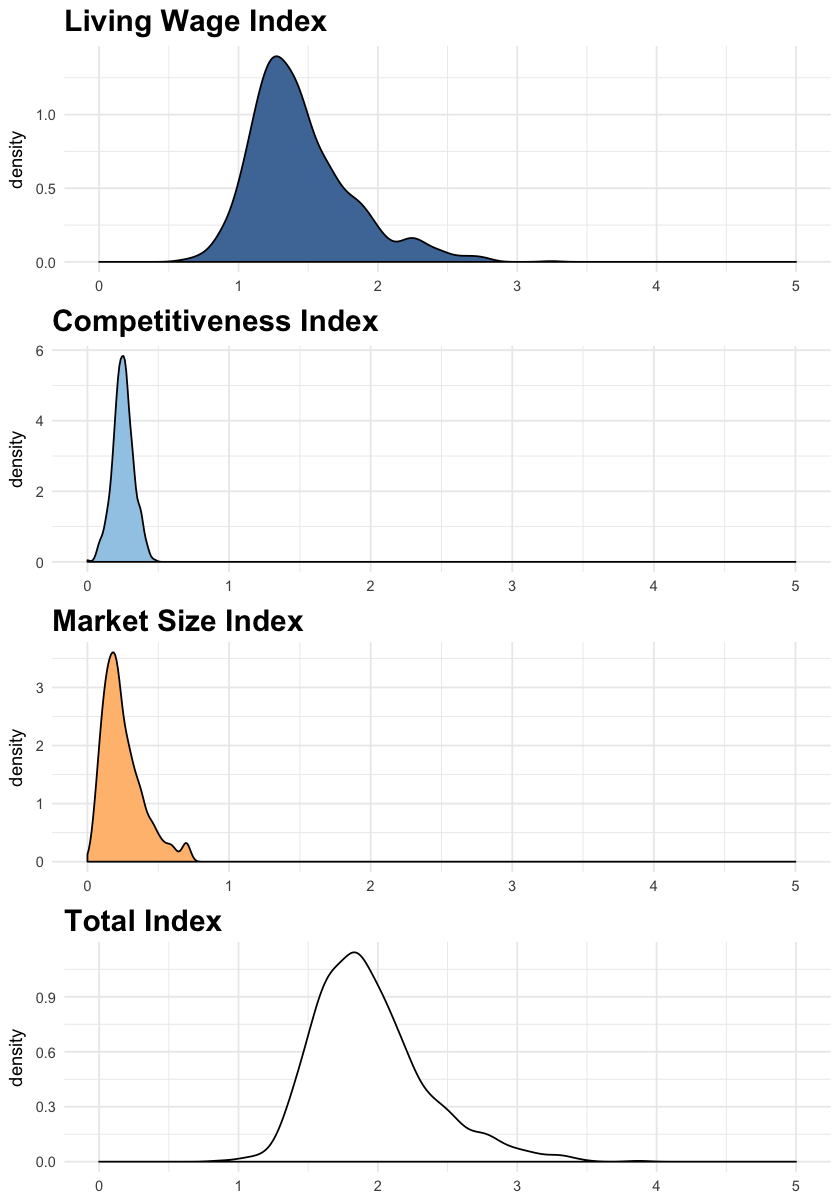

In [20]:
fullmerged[,living.wage.index := median.wage/annual.wage]
fullmerged[,comp.index := 6 * avg.days / avg.clicks]
fullmerged[,market.size.index := 40 * num.jobs / unemployed]
fullmerged[,market.size.index := ifelse(market.size.index > 0.7, 0.7, market.size.index)]
fullmerged[,total.index := living.wage.index + comp.index + market.size.index]
fullmerged <- fullmerged[state != "HI"]

p1 <- fullmerged %>% 
        ggplot() + 
            aes(x=living.wage.index, fill=T) +
            geom_density(show.legend=F) + 
            ggtitle('Living Wage Index') + 
            theme_minimal() + 
            scale_fill_manual(values="#4E79A7") + 
            theme(axis.title.x=element_blank(),
                    plot.title=element_text(face="bold", size=18)) + 
            xlim(0,5)

p2 <- fullmerged %>%
        ggplot() + 
            aes(x=comp.index, fill="blue") + 
            geom_density(show.legend=F) + 
            ggtitle('Competitiveness Index') + 
            theme_minimal() + 
            scale_fill_manual(values="#A0CBE8") +      
            theme(axis.title.x=element_blank(),
                    plot.title=element_text(face="bold", size=18)) + 
            xlim(0,5)

p3 <- fullmerged %>%
        ggplot() + 
            aes(x=market.size.index, fill="blue") + 
            geom_density(show.legend=F) + 
            ggtitle('Market Size Index') + 
            theme_minimal() + 
            scale_fill_manual(values="#FFBE7D") + 
            theme(axis.title.x=element_blank(),
                    plot.title=element_text(face="bold", size=18)) + 
            xlim(0,5)

p4 <- fullmerged %>% 
        ggplot() + 
            aes(x=total.index, fill="blue") + 
            geom_density(show.legend=F) +
            ggtitle('Total Index') + 
            theme_minimal() + 
            scale_fill_manual(values="#FFFFFF") + 
            theme(axis.title.x=element_blank(),
                    plot.title=element_text(face="bold", size=18)) + 
            xlim(0,5)

options(repr.plot.width=7, repr.plot.height=10)
ggarrange(p1,p2,p3,p4, nrow=4)

<br>
***
## Results

In our analysis, the Living Wage index comprised three fourths of the total, while the other two comprise one eighth each. What good are high wages if there are no jobs, and what good comes from a plentiful job market if they're low paying? The mean of the Living Wage Index was roughly 1.5, while the mean of the other two were 0.25, so the mean of the total is roughly 2. This high proportion of wages to the other two indicies was neccessary because counties with LWI less than 0.8 appeared in the fourth quartile of the total score, which was unacceptable.

The Market Size Index had some huge outliers that were neccessary to neutralize, hence limiting the maximum value earlier.

In [23]:
library(data.table)
library(OneR)
library(plyr)
library(dplyr)
library(plotly)
library(htmlwidgets)
fullmerged[, Quartile := bin(total.index, method="content",4)]
fullmerged[, Quartile := mapvalues(fullmerged[,Quartile], 
                                   from=c("(0.866,1.67]",
                                          "(1.67,1.88]",
                                          "(1.88,2.16]",
                                          "(2.16,3.87]"), 
                                   to=c("First Quartile",
                                        "Second Quartile",
                                        "Third Quartile",
                                        "Fourth Quartile"))]

fullmerged[,county.label := paste(county, state)]

p <- plot_ly(fullmerged, 
            x=~living.wage.index, 
            y=~market.size.index, 
            z=~comp.index, 
            color=~Quartile, 
            text=~county.label) %>% 
        add_markers() %>% 
        layout(title="Total Index")

embed_notebook(p)

<iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxodG1sPgo8aGVhZD4KPG1ldGEgY2hhcnNldD0idXRmLTgiIC8+Cjx0aXRsZT5wbG90bHk8L3RpdGxlPgo8c2NyaXB0PihmdW5jdGlvbigpIHsKICAvLyBJZiB3aW5kb3cuSFRNTFdpZGdldHMgaXMgYWxyZWFkeSBkZWZpbmVkLCB0aGVuIHVzZSBpdDsgb3RoZXJ3aXNlIGNyZWF0ZSBhCiAgLy8gbmV3IG9iamVjdC4gVGhpcyBhbGxvd3MgcHJlY2VkaW5nIGNvZGUgdG8gc2V0IG9wdGlvbnMgdGhhdCBhZmZlY3QgdGhlCiAgLy8gaW5pdGlhbGl6YXRpb24gcHJvY2VzcyAodGhvdWdoIG5vbmUgY3VycmVudGx5IGV4aXN0KS4KICB3aW5kb3cuSFRNTFdpZGdldHMgPSB3aW5kb3cuSFRNTFdpZGdldHMgfHwge307CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIGEgdmlld2VyIHBhbmUuIElmIG5vdCwgd2UncmUgaW4gYSB3ZWIgYnJvd3Nlci4KICB2YXIgdmlld2VyTW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy52aWV3ZXJNb2RlID0KICAgICAgL1xidmlld2VyX3BhbmU9MVxiLy50ZXN0KHdpbmRvdy5sb2NhdGlvbik7CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIFNoaW55IG1vZGUuIElmIG5vdCwgaXQncyBhIHN0YXRpYyBkb2N1bWVudC4KICAvLyBOb3RlIHRoYXQgc3RhdGljIHdpZGdldHMgY2FuIGFwcGVhciBpbiBib3RoIFNoaW55IGFuZCBzdGF0aWMgbW9kZXMsIGJ1dAogIC8vIG9idmlvdXNseSwgU2hpbnkgd2lkZ2V0cyBjYW4gb25seSBhcHBlYXIgaW4gU2hpbnkgYXBwcy9kb2N1bWVudHMuCiAgdmFyIHNoaW55TW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy5zaGlueU1vZGUgPQogICAgICB0eXBlb2Yod2luZG93LlNoaW55KSAhPT0gInVuZGVmaW5lZCIgJiYgISF3aW5kb3cuU2hpbnkub3V0cHV0QmluZGluZ3M7CgogIC8vIFdlIGNhbid0IGNvdW50IG9uIGpRdWVyeSBiZWluZyBhdmFpbGFibGUsIHNvIHdlIGltcGxlbWVudCBvdXIgb3duCiAgLy8gdmVyc2lvbiBpZiBuZWNlc3NhcnkuCiAgZnVuY3Rpb24gcXVlcnlTZWxlY3RvckFsbChzY29wZSwgc2VsZWN0b3IpIHsKICAgIGlmICh0eXBlb2YoalF1ZXJ5KSAhPT0gInVuZGVmaW5lZCIgJiYgc2NvcGUgaW5zdGFuY2VvZiBqUXVlcnkpIHsKICAgICAgcmV0dXJuIHNjb3BlLmZpbmQoc2VsZWN0b3IpOwogICAgfQogICAgaWYgKHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwpIHsKICAgICAgcmV0dXJuIHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwoc2VsZWN0b3IpOwogICAgfQogIH0KCiAgZnVuY3Rpb24gYXNBcnJheSh2YWx1ZSkgewogICAgaWYgKHZhbHVlID09PSBudWxsKQogICAgICByZXR1cm4gW107CiAgICBpZiAoJC5pc0FycmF5KHZhbHVlKSkKICAgICAgcmV0dXJuIHZhbHVlOwogICAgcmV0dXJuIFt2YWx1ZV07CiAgfQoKICAvLyBJbXBsZW1lbnQgalF1ZXJ5J3MgZXh0ZW5kCiAgZnVuY3Rpb24gZXh0ZW5kKHRhcmdldCAvKiwgLi4uICovKSB7CiAgICBpZiAoYXJndW1lbnRzLmxlbmd0aCA9PSAxKSB7CiAgICAgIHJldHVybiB0YXJnZXQ7CiAgICB9CiAgICBmb3IgKHZhciBpID0gMTsgaSA8IGFyZ3VtZW50cy5sZW5ndGg7IGkrKykgewogICAgICB2YXIgc291cmNlID0gYXJndW1lbnRzW2ldOwogICAgICBmb3IgKHZhciBwcm9wIGluIHNvdXJjZSkgewogICAgICAgIGlmIChzb3VyY2UuaGFzT3duUHJvcGVydHkocHJvcCkpIHsKICAgICAgICAgIHRhcmdldFtwcm9wXSA9IHNvdXJjZVtwcm9wXTsKICAgICAgICB9CiAgICAgIH0KICAgIH0KICAgIHJldHVybiB0YXJnZXQ7CiAgfQoKICAvLyBJRTggZG9lc24ndCBzdXBwb3J0IEFycmF5LmZvckVhY2guCiAgZnVuY3Rpb24gZm9yRWFjaCh2YWx1ZXMsIGNhbGxiYWNrLCB0aGlzQXJnKSB7CiAgICBpZiAodmFsdWVzLmZvckVhY2gpIHsKICAgICAgdmFsdWVzLmZvckVhY2goY2FsbGJhY2ssIHRoaXNBcmcpOwogICAgfSBlbHNlIHsKICAgICAgZm9yICh2YXIgaSA9IDA7IGkgPCB2YWx1ZXMubGVuZ3RoOyBpKyspIHsKICAgICAgICBjYWxsYmFjay5jYWxsKHRoaXNBcmcsIHZhbHVlc1tpXSwgaSwgdmFsdWVzKTsKICAgICAgfQogICAgfQogIH0KCiAgLy8gUmVwbGFjZXMgdGhlIHNwZWNpZmllZCBtZXRob2Qgd2l0aCB0aGUgcmV0dXJuIHZhbHVlIG9mIGZ1bmNTb3VyY2UuCiAgLy8KICAvLyBOb3RlIHRoYXQgZnVuY1NvdXJjZSBzaG91bGQgbm90IEJFIHRoZSBuZXcgbWV0aG9kLCBpdCBzaG91bGQgYmUgYSBmdW5jdGlvbgogIC8vIHRoYXQgUkVUVVJOUyB0aGUgbmV3IG1ldGhvZC4gZnVuY1NvdXJjZSByZWNlaXZlcyBhIHNpbmdsZSBhcmd1bWVudCB0aGF0IGlzCiAgLy8gdGhlIG92ZXJyaWRkZW4gbWV0aG9kLCBpdCBjYW4gYmUgY2FsbGVkIGZyb20gdGhlIG5ldyBtZXRob2QuIFRoZSBvdmVycmlkZGVuCiAgLy8gbWV0aG9kIGNhbiBiZSBjYWxsZWQgbGlrZSBhIHJlZ3VsYXIgZnVuY3Rpb24sIGl0IGhhcyB0aGUgdGFyZ2V0IHBlcm1hbmVudGx5CiAgLy8gYm91bmQgdG8gaXQgc28gInRoaXMiIHdpbGwgd29yayBjb3JyZWN0bHkuCiAgZnVuY3Rpb24gb3ZlcnJpZGVNZXRob2QodGFyZ2V0LCBtZXRob2ROYW1lLCBmdW5jU291cmNlKSB7CiAgICB2YXIgc3VwZXJGdW5jID0gdGFyZ2V0W21ldGhvZE5hbWVdIHx8IGZ1bmN0aW9uKCkge307CiAgICB2YXIgc3VwZXJGdW5jQm91bmQgPSBmdW5jdGlvbigpIHsKICAgICAgcmV0dXJuIHN1cGVyRnVuYy5hcHBseSh0YXJnZXQsIGFyZ3VtZW50cyk7CiAgICB9OwogICAgdGFyZ2V0W21ldGhvZE5hbWVdID0gZnVuY1NvdXJjZShzdXBlckZ1bmNCb3VuZCk7CiAgfQoKICAvLyBBZGQgYSBtZXRob2QgdG8gZGVsZWdhdG9yIHRoYXQsIHdoZW4gaW52b2tlZCwgY2FsbHMKICAvLyBkZWxlZ2F0ZWUubWV0aG9kTmFtZS4gSWYgdGhlcmUgaXMgbm8gc3VjaCBtZXRob2Qgb24KICAvLyB0aGUgZGVsZWdhdGVlLCBidXQgdGhlcmUgd2FzIG9uZSBvbiBkZWxlZ2F0b3IgYmVmb3JlCiAgLy8gZGVsZWdhdGVNZXRob2Qgd2FzIGNhbGxlZCwgdGhlbiB

This is an interactive plot with `plotly`. **Note: there is an issue with Github displaying the 3d graph.** It's immediately striking that there's lot more variance in fourth quartile counties versus all others. Nobody has it all: there aren't many counties with high wages, a lot of jobs, and low competition. Most notably, *there are very few counties with high wages and a large job market*. This follows basic economic principles: as the supply of labor goes down with demand held constant, wages rise. However, even though these well-paid county markets are small they tend to have low competition, to the benefit of the workers.
<br>
We also note that in smaller job markets, there is much more variance in the LWI than in larger ones. In other words, in small markets, there tends to be a greater spread in salary proportional to the living wage. There are relatively more jobs that pay a much greater proportion than the cost of living, but there are also relatively more jobs that pay in a lesser proportion relative to the mean. In larger markets, the spread isn't as great. What could be the cause of this? I suspect that this could be explained by regional economic trends: there are large differences between rural job markets and it is not fair to lump them together and stereotype them as poor and impoverished. 
In fact, there are many well-to-do small towns and cities, or at least places offering well-paid unskilled jobs. For example, North Dakota has many high-paying jobs in the petroleum industry. The working conditions are not great, but an unskilled worker has the chance to make $100,000 per year relatively easily. On average, however, rural areas *are* poorer than urban ones, and there are many, many small towns who have been left behind by the Great Recession.

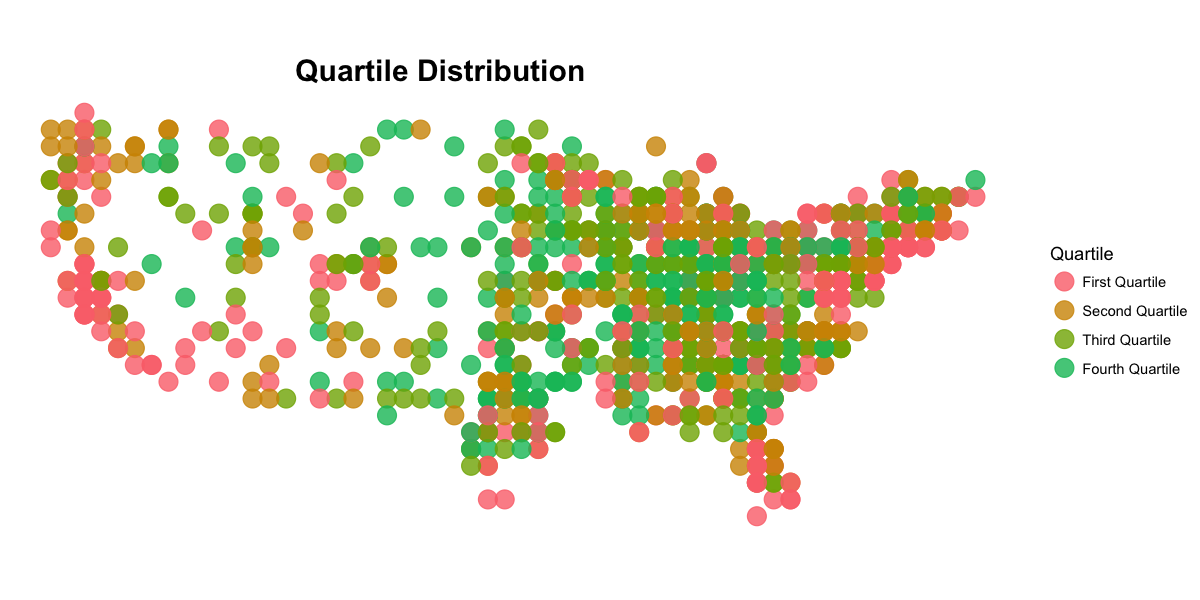

In [25]:
graph <- fullmerged %>% 
            ggplot() + 
                geom_point(aes(x=round(INTPTLONG),
                                 y=round(INTPTLAT),
                                 color=Quartile),
                             size=5,
                             alpha=0.8) + 
                coord_fixed() + 
                theme_void() +  
                scale_colour_hue(h = c(10,150)) + 
                ggtitle("Quartile Distribution") + 
                theme(plot.title=element_text(hjust=0.4,
                                                face="bold",
                                                size=18))

options(repr.plot.width=10, repr.plot.height=5)
print(graph)

It's easy to see that the worst job markets for unskilled workers are mostly along the coasts, and are particularly bad in most of California and the Northeast. The best areas to live are clustered in the heartland: it's safe to say that in terms of regions, the Midwest wins. A large fraction of the counties in this area are in the third or fourth quartile. The West (excluding California, Oregon, and Washington) is also promising, but suffers from a lack of data.